In [1]:
import string
import random
import unicodedata
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

torch.cuda.manual_seed_all(17)
random.seed(17)

device = torch.device("cuda:1")
valid_chars = string.ascii_letters + string.digits + """ .,:;"'()[]!?+=/"""
num_chars = len(valid_chars) + 2

class Corpus(Dataset):
    def __init__(self, file):
        self.file = file
        self.mapping = self._get_mapping()
        self.text = self._load_text()
        
    def sentence_to_tensor(self, sentence):
        """
        Returns a tensor of shape (chars, onehot)
        """
        sentence_tensor = torch.Tensor(len(sentence), len(self.mapping))
        for position in range(len(sentence)):
            character = sentence[position]
            sentence_tensor[position] = self.one_hot(character)
        return sentence_tensor
    
    def get_label_from_tensor(self, sequence):
        """
        Returns a tensor shifted by one to the left,
        with an EOS ('|') tag at the end.
        """
        label_tensor = torch.Tensor(len(sequence))
        for position in range(len(sequence) - 1):
            character = torch.argmax(sequence[position + 1])
            label_tensor[position] = character
        label_tensor[-1] = self.mapping['|']
        return label_tensor
    
    def _load_text(self):
        with open(self.file) as f:
            return f.read().strip().split('\n')
        
    def _get_mapping(self):
        mapping = {}
        mapping['*'] = 0
        for idx in range(1, len(valid_chars) + 1):
            mapping[valid_chars[idx - 1]] = idx
        mapping['|'] = len(valid_chars) + 1
        return mapping
    
    def one_hot(self, character):
        """
        Transforms a single character toa one-hot tensor.
        """
        one_hot = torch.zeros(len(self.mapping))
        index = torch.Tensor([self.mapping[character]])
        one_hot = one_hot.scatter(0, index.long(), 1)
        return one_hot
    
    def split(self, train_ratio, val_ratio, test_ratio):
        if (train_ratio + val_ratio + test_ratio != 1.0):
            raise Exception("Ratios should sum to one.")
        dataset_length = len(self)
        train_length = int(train_ratio * dataset_length)
        val_length = int(val_ratio * dataset_length)
        test_length = len(self) - train_length - val_length
        splits = [train_length, val_length, test_length]
        return random_split(self, splits)
    
    def __getitem__(self, idx):
        """
        Returns:
            sequence: tensor of shape (chars, onehot)
            length: int length of sequence
            label: shifted tensor of shape (chars, onehot)
        """
        sequence = self.sentence_to_tensor(self.text[idx])
        length = len(sequence)
        label = self.get_label_from_tensor(sequence)
        return sequence, length, label
    
    def __len__(self):
        return len(self.text)

class SpockNet(nn.Module):
    def __init__(self, num_chars, hidden_size, num_layers, dropout=0.5):
        super(SpockNet, self).__init__()
        self.num_chars = num_chars
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(num_chars, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_chars)
        
    def forward(self, sentence, lengths, hc):
        batch_size, sequence_length = sentence.size()[:-1]
        sentence = pack_padded_sequence(sentence, lengths, batch_first=True)
        lstm_out, hc = self.lstm(sentence, hc)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True, padding_value=0)
        lstm_out = lstm_out.contiguous()
        lstm_out = lstm_out.view(-1, lstm_out.shape[2])
        output = self.fc(lstm_out)
        output = output.view(batch_size, sequence_length, self.num_chars)
        return output, hc

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device),
            weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device))
        return hidden

class Batch:
    def __init__(self, batch):
        # batch: list of N tuples of (data (tensor), length (int), label (tensor))
        batch.sort(reverse=True, key=lambda x: x[1])
        data, _, label = zip(*batch)
        self.lengths = torch.Tensor([len(d) for d in data])
        self.data = pad_sequence(data, batch_first=True)
        self.label = pad_sequence(label, batch_first=True)
        
def batch_function(batch):
    return Batch(batch)

![image](https://i.stack.imgur.com/SjnTl.png)

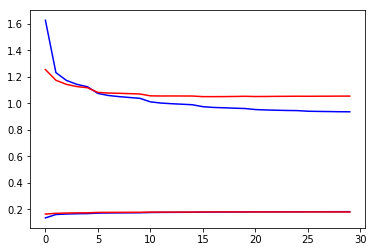

In [17]:
from IPython.display import clear_output
from time import time

corpus = Corpus('clean.txt')
train, val, test = corpus.split(0.8, 0.2, 0)

mapping = list(corpus.mapping.keys())

batch_size = 32
model = SpockNet(num_chars, 200, 2, dropout=0.1).to(device)
train_loader = DataLoader(train, collate_fn=batch_function, batch_size=batch_size, num_workers=8)
val_loader = DataLoader(val, collate_fn=batch_function, batch_size=batch_size, num_workers=8)

start_letters = 'ABCDEFGHIJKLMNOPRSTUVWZ'
max_sampling_length = 500
temperature = 0.5

def get_sample(model, hc):
    model.eval()
    mapping = list(corpus.mapping.keys())
    letter = random.choice(start_letters)
    prediction = letter
    letter_tensor = corpus.one_hot(letter).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        hc = model.init_hidden(1)
        while (letter != '|') and (len(prediction) < max_sampling_length):
            output, hc = model(letter_tensor, torch.tensor([1]), hc)
            distribution = torch.softmax(torch.div(torch.flatten(output), temperature), dim=0)
            distribution = torch.distributions.multinomial.Multinomial(1, distribution)
            sample = distribution.sample()
            letter = mapping[torch.argmax(sample)]
            if letter != '|':
                prediction += letter
            letter_tensor = corpus.one_hot(letter).unsqueeze(0).unsqueeze(0).to(device)
    return prediction

def run_train(epoch):
    train_loss = []
    train_accs = []
    true_positive = 0
    sample_count = 0
    for idx, batch in enumerate(train_loader):
        model.train()
        start = time()
        optimizer.zero_grad()
        input = batch.data.to(device)
        target = batch.label.to(device)
        lengths = batch.lengths.to(device)
        hc = model.init_hidden(len(input))
        output, _ = model(input, lengths, hc)
        output = output.to(device)
        output = output.view(-1, num_chars)
        target = target.view(-1)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()
        _, pred = torch.max(output, dim=1)
        sample_count += len(output)
        true_positive += torch.sum(pred == target.long())
        train_acc = (true_positive.float() / sample_count)
        train_loss.append(loss.item())
        train_accs.append(train_acc)
        if idx % 200 == 0:
            clear_output(wait=True)
            print("Epoch {} | Training batch {}/{} ({}%)".format(epoch, idx + 1, len(train_loader),
                    int((idx + 1) / len(train_loader) * 100)))
            print("Training loss: {} | Training accuracy: {} | Time per batch: {}".format(loss.item(),
                    train_acc, time() - start))
            prediction = get_sample(model, epoch)
            print(prediction)

    with open('temperature_sample_epoch_{}'.format(epoch), 'a') as file:
        for i in range(20):
            prediction = get_sample(model, epoch)
            file.write(prediction)
    return train_loss, train_acc

def run_validate(epoch):
    model.eval()
    with torch.no_grad():
        val_loss = 0
        true_positive = 0
        sample_count = 0
        start = time()
        for idx, batch in enumerate(val_loader):
            input = batch.data.to(device)
            target = batch.label.to(device)
            lengths = batch.lengths.to(device)
            hc = model.init_hidden(len(input))
            output, _ = model(input, lengths, hc)
            output = output.to(device)
            output = output.view(-1, num_chars)
            target = target.view(-1)
            loss = criterion(output, target.long())
            val_loss += loss
            _, pred = torch.max(output, dim=1)
            sample_count += len(output)
            true_positive += torch.sum(pred == target.long())
            clear_output(wait=True)
            print("Epoch {} | Validating batch {}/{} ({}%)".format(epoch, idx + 1, len(val_loader),
                                                        int((idx + 1) / len(val_loader) * 100)))
        clear_output(wait=True)
        print("Epoch {} | Validating batch {}/{} ({}%)".format(epoch, idx + 1, len(val_loader),
                                                    int((idx + 1) / len(val_loader) * 100)))
        val_acc = (true_positive.float() / sample_count)
        val_loss /= len(val_loader)
        print("Validation loss: {} | Validation accuracy: {} | Time for validation: {}".format(val_loss.item(),
                val_acc, time() - start))
    return val_loss.item(), val_acc

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})

num_epochs = 30
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

experiment = '2'

for epoch in range(1, num_epochs + 1):
    scheduler.step()
    train_loss, train_acc = run_train(epoch)
    val_loss, val_acc = run_validate(epoch)
    training_losses.append(torch.mean(torch.Tensor(train_loss)))
    training_accuracies.append(train_acc)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_acc)
    
    torch.save(model.state_dict(), 'experiment-{}/model_{}.pt'.format(experiment))
    with open('epoch_{}.txt'.format(experiment), 'a') as f:
        f.write(str(epoch) + ' ')
    
    clear_output(wait=True)
    ta = np.array([x.item() for x in training_accuracies]) *100
    va = np.array([x.item() for x in validation_accuracies]) *100
    fig, ax = plt.subplots(figsize=(16,9))
    ax2 = ax.twinx()
    ax.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    ax.plot(training_losses, '--', linewidth=4, label="Training loss")
    ax.plot(validation_losses, 'r--', linewidth=4, label="Validation loss")
    ax2.plot(ta, linewidth=4, label="Training acc")
    ax2.plot(va, 'r', linewidth=4, label="Validation acc")
    ax.legend(loc='center', bbox_to_anchor=(0.8, 0.3))
    ax2.legend(loc='center', bbox_to_anchor=(0.8, 0.8))
    plt.show()